Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 53.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.69MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



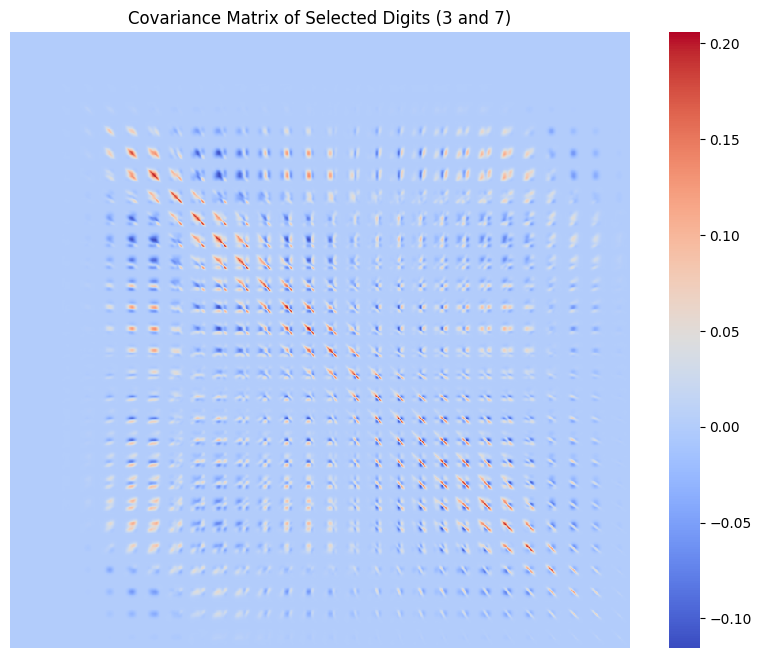

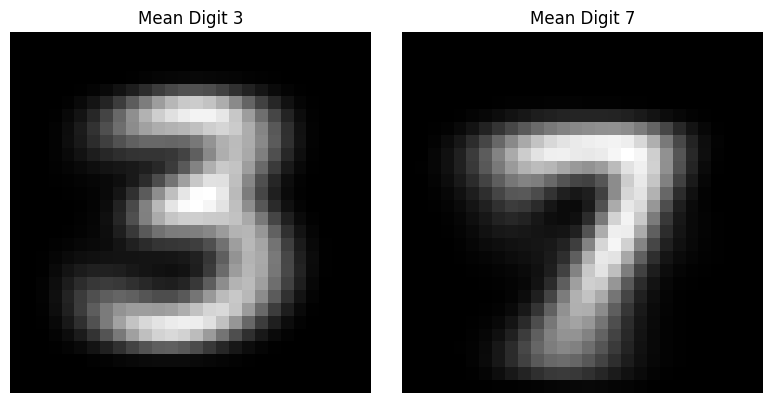

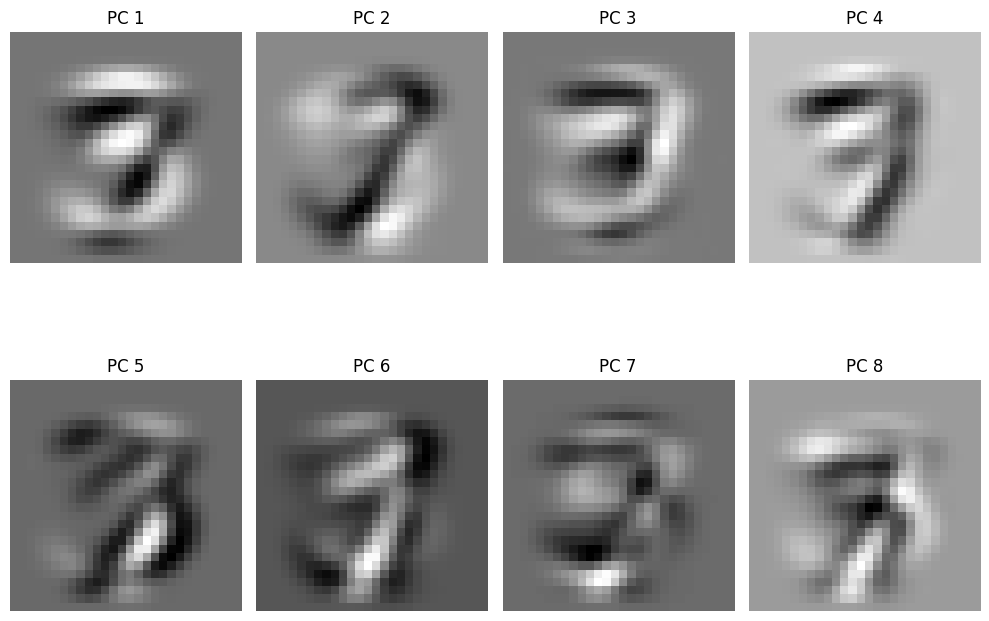

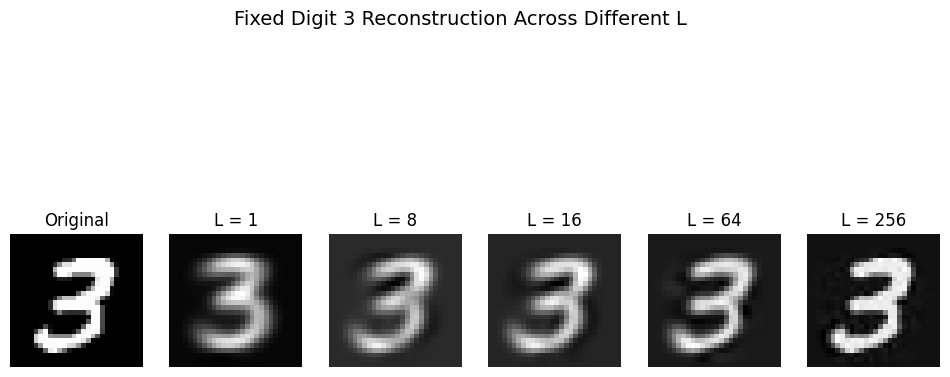

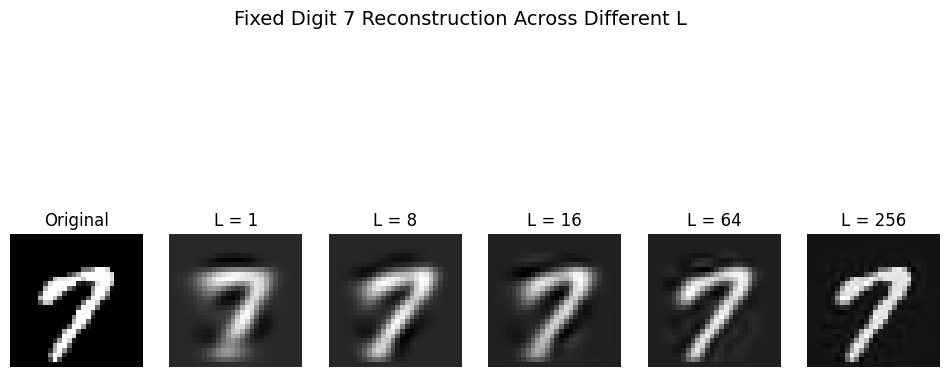

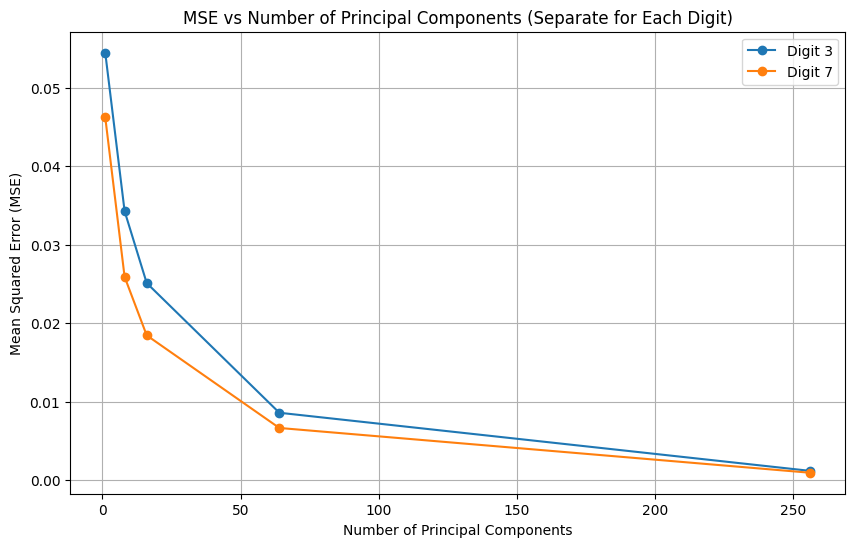

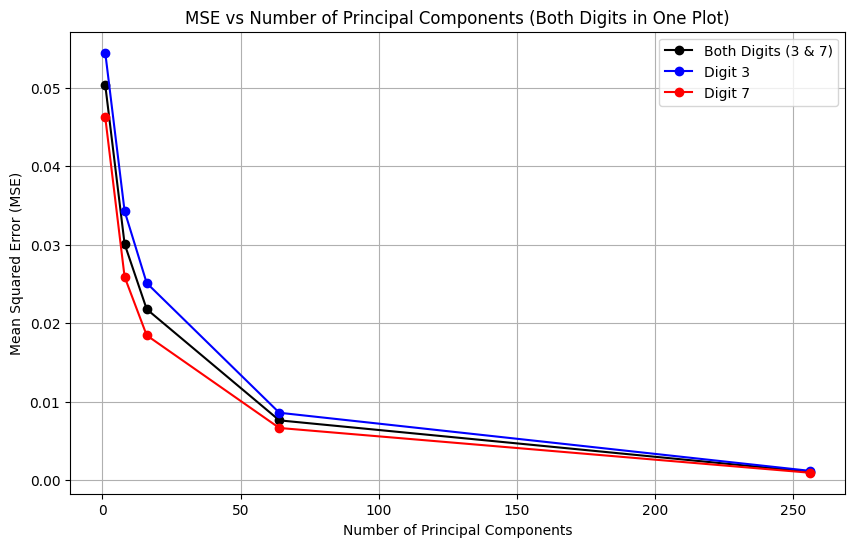

,3,7
1,0.054449,0.046220
8,0.034271,0.025898
16,0.025106,0.018443
64,0.008580,0.006642
256,0.001180,0.000940


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision import datasets, transforms
from IPython.display import display

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Extract data and labels
data = mnist.data.numpy().reshape(-1, 28 * 28) / 255.0  # Normalize to [0, 1]
labels = mnist.targets.numpy()

# Select two digits (e.g., 3 and 7)
digits = [3, 7]
mask = np.isin(labels, digits)
digit_data = data[mask]
digit_labels = labels[mask]

# Compute mean image for full dataset
mean_image = np.mean(digit_data, axis=0)

# Compute mean images per digit
mean_images_per_digit = {digit: np.mean(digit_data[digit_labels == digit], axis=0) for digit in digits}

# Compute covariance matrix
mean_centered = digit_data - mean_image
cov_matrix = np.cov(mean_centered, rowvar=False)

# Plot covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title("Covariance Matrix of Selected Digits (3 and 7)")
plt.show()

# Plot mean images per digit
plt.figure(figsize=(8, 4))
for i, digit in enumerate(digits):
    plt.subplot(1, len(digits), i + 1)
    plt.imshow(mean_images_per_digit[digit].reshape(28, 28), cmap='gray')
    plt.title(f'Mean Digit {digit}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# PCA using SVD
def PCA(data, mean_image, components_list):
    mean_centered = data - mean_image
    U, Sigma, Vt = np.linalg.svd(mean_centered, full_matrices=False)
    reconstructions = {}
    mse_list = []

    for L in components_list:
        U_L = U[:, :L]
        Sigma_L = np.diag(Sigma[:L])
        Vt_L = Vt[:L, :]
        A_star = U_L @ Sigma_L @ Vt_L

        # Reconstruct the original data using A_star and adding the mean back
        reconstructed = A_star + mean_image
        reconstructions[L] = reconstructed

        # Compute MSE
        mse = np.mean((data - reconstructed) ** 2)
        mse_list.append(mse)

    return reconstructions, Vt, mse_list

# Apply PCA on the full dataset
components_list = [1, 8, 16, 64, 256]
reconstructions, Vt, mse = PCA(digit_data, mean_image, components_list)

# Plot first 8 PCA components
def plot_pca_components(Vt):
    plt.figure(figsize=(10, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(Vt[i].reshape(28, 28), cmap='gray')
        plt.title(f'PC {i + 1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_pca_components(Vt)

# Select one fixed digit sample for each digit
digit_samples = {}
for digit in digits:
    digit_samples[digit] = digit_data[np.where(digit_labels == digit)[0][0]]  # First occurrence of the digit

# Function to plot original vs. reconstructed digits across different L values
def plot_fixed_reconstructions(digit_samples, reconstructions, components_list):
    for digit, original_img in digit_samples.items():
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'Fixed Digit {digit} Reconstruction Across Different L', fontsize=14)

        # Plot original image
        plt.subplot(1, len(components_list) + 1, 1)
        plt.imshow(original_img.reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Plot reconstructions for different L values
        for i, L in enumerate(components_list):
            reconstructed_img = reconstructions[L][np.where(digit_labels == digit)[0][0]]  # Use the fixed index
            plt.subplot(1, len(components_list) + 1, i + 2)
            plt.imshow(reconstructed_img.reshape(28, 28), cmap='gray')
            plt.title(f'L = {L}')
            plt.axis('off')

        plt.show()

# Plot fixed reconstructions
plot_fixed_reconstructions(digit_samples, reconstructions, components_list)

# Compute reconstruction errors per digit
errors_per_digit = {L: {digit: [] for digit in digits} for L in components_list}

for i, label in enumerate(digit_labels):
    for L, reconstructed in reconstructions.items():
        error = np.mean((digit_data[i] - reconstructed[i]) ** 2)
        errors_per_digit[L][label].append(error)

# Plot MSE separately for each digit
plt.figure(figsize=(10, 6))
for digit in digits:
    mse_digit = [np.mean(errors_per_digit[L][digit]) for L in components_list]
    plt.plot(components_list, mse_digit, marker='o', linestyle='-', label=f'Digit {digit}')

plt.title('MSE vs Number of Principal Components (Separate for Each Digit)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot MSE for both digits in the same figure
plt.figure(figsize=(10, 6))
mse_combined = [np.mean([np.mean(errors_per_digit[L][3]), np.mean(errors_per_digit[L][7])]) for L in components_list]

plt.plot(components_list, mse_combined, marker='o', linestyle='-', label='Both Digits (3 & 7)', color='black')
plt.plot(components_list, [np.mean(errors_per_digit[L][3]) for L in components_list], marker='o', linestyle='-', label='Digit 3', color='blue')
plt.plot(components_list, [np.mean(errors_per_digit[L][7]) for L in components_list], marker='o', linestyle='-', label='Digit 7', color='red')

plt.title('MSE vs Number of Principal Components (Both Digits in One Plot)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Create dataframe with mean MSE per digit
mse_per_digit = {L: {digit: np.mean(errors_per_digit[L][digit]) for digit in digits} for L in components_list}
mse_df = pd.DataFrame(mse_per_digit).T  # Convert to DataFrame

# Display MSE table
display(mse_df)


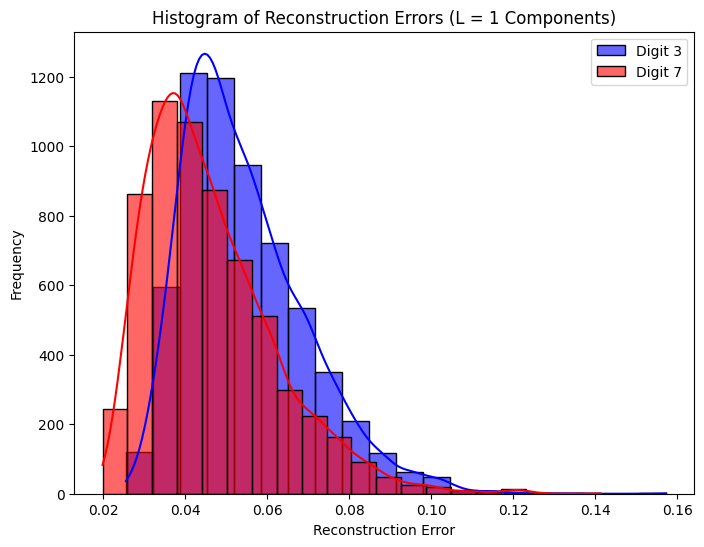

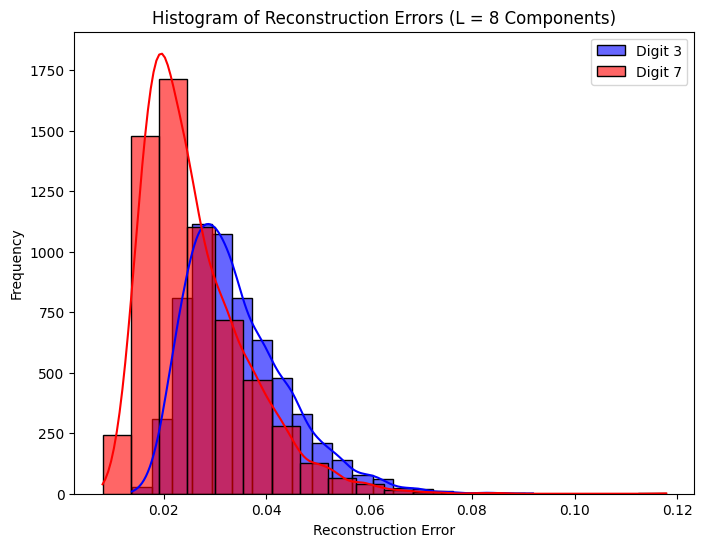

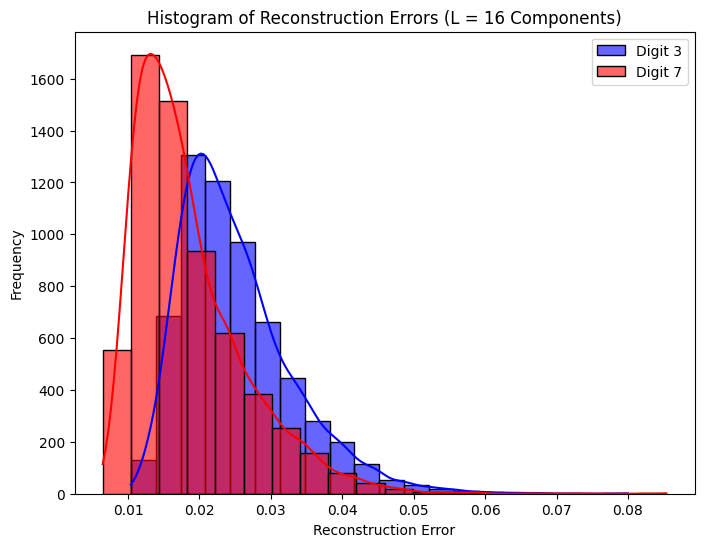

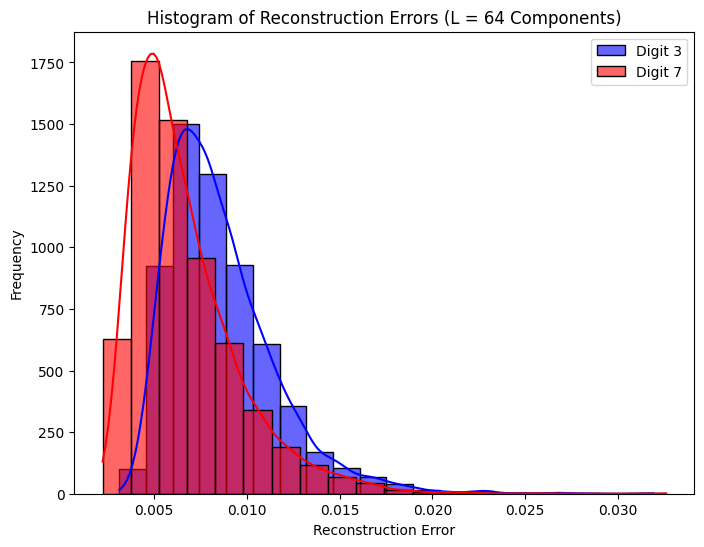

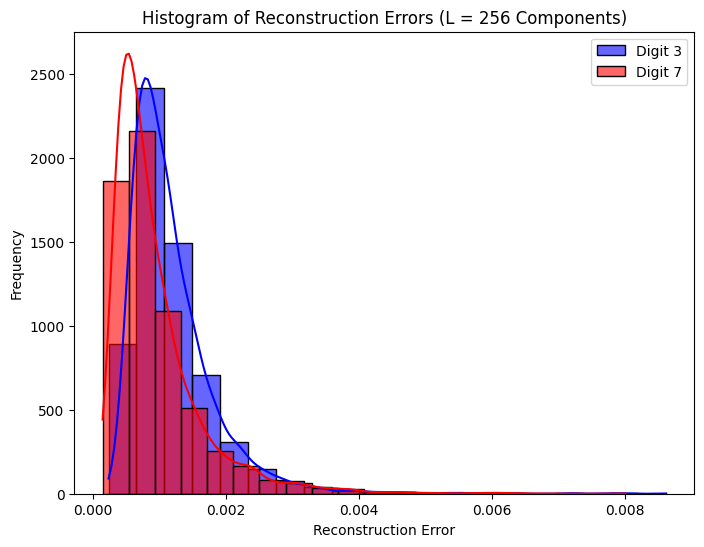

In [3]:
# For each L value, plot the histogram of reconstruction errors for each digit.
for L in components_list:
    plt.figure(figsize=(8, 6))
    for digit, color in zip(digits, ['blue', 'red']):
        error_vals = errors_per_digit[L][digit]
        sns.histplot(error_vals, kde=True, color=color, bins=20, label=f'Digit {digit}', alpha=0.6)
    plt.title(f'Histogram of Reconstruction Errors (L = {L} Components)')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

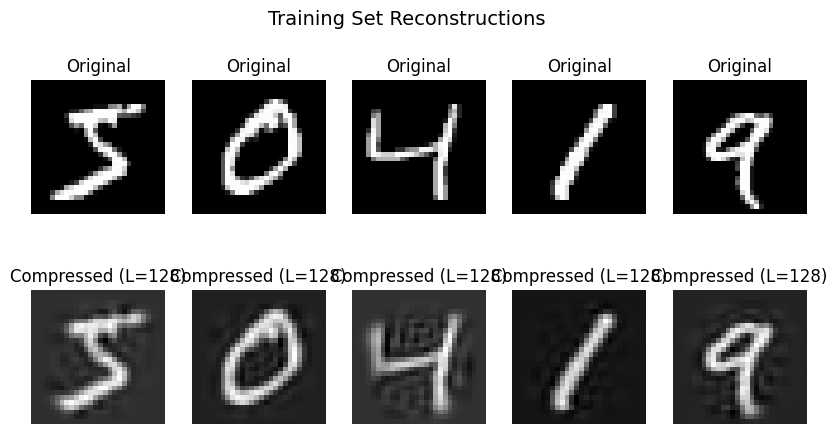

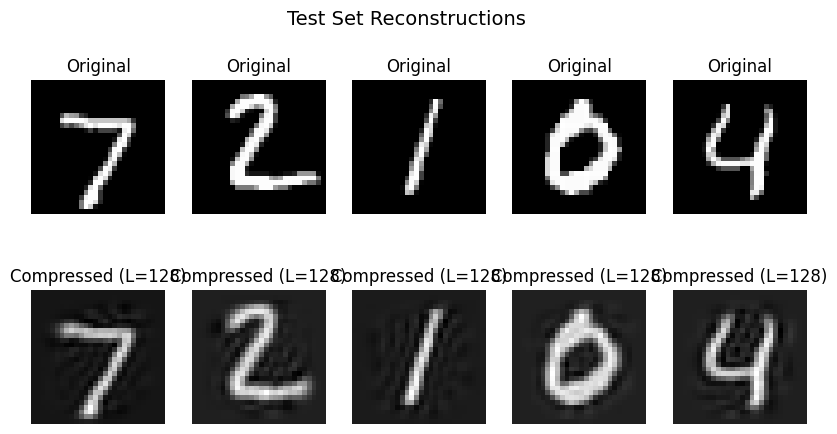

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Load MNIST training and test data
transform = transforms.Compose([transforms.ToTensor()])

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Extract training and test data as NumPy arrays
train_data = mnist_train.data.numpy().reshape(-1, 28 * 28) / 255.0  # Normalize to [0,1]
test_data = mnist_test.data.numpy().reshape(-1, 28 * 28) / 255.0

# Compute mean image from training data
mean_image = np.mean(train_data, axis=0)

# PCA using SVD (Compute V_L for L=128)
L = 128  # Number of principal components
mean_centered_train = train_data - mean_image  # Centering training data
U, Sigma, Vt = np.linalg.svd(mean_centered_train, full_matrices=False)

V_L = Vt[:L, :]  # Select first 128 principal components (V_L)

# (α) Reconstruct compressed training data using V_L
compressed_train = mean_centered_train @ V_L.T  # Project training data onto PCA space
reconstructed_train = (compressed_train @ V_L) + mean_image  # Reconstruct

# (β) Compress and reconstruct test data using the same V_L
mean_centered_test = test_data - mean_image  # Centering test data using training mean
compressed_test = mean_centered_test @ V_L.T  # Project test data onto PCA space
reconstructed_test = (compressed_test @ V_L) + mean_image  # Reconstruct test images

# Function to plot original vs compressed images
def plot_reconstructions(original, reconstructed, num_samples=5, title="Reconstructed Images"):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        # Original image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Compressed (L=128)")
        plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.show()

# Plot reconstructions for training set
plot_reconstructions(train_data, reconstructed_train, num_samples=5, title="Training Set Reconstructions")

# Plot reconstructions for test set
plot_reconstructions(test_data, reconstructed_test, num_samples=5, title="Test Set Reconstructions")
